In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, './orchard')

from orchard.find_missing_trees import *
from orchard.aerobotics_requests import *

In [2]:
orchard_id = 216269

### Step 1: Get the orchard details and the coordinates of trees from the latest survey

In [3]:
# Details of orchard; for polygon 
single_orchard_response = fetch_single_orchard(orchard_id)

# Get teh details of all surveys for current orchard
survey_response = fetch_all_orchard_surveys(orchard_id)
surveys = survey_response.json()["results"]  # TODO: Need to handle pagination
surveys_sorted_by_date = sorted(surveys, key=lambda survey: survey["date"])
latest_survey_id = surveys_sorted_by_date[-1]["id"]

# Get the trees for the latest survey
tree_surveys_response = fetch_single_survey(latest_survey_id)
tree_surveys = tree_surveys_response.json()

In [4]:
# ### Single Call
# m = find_all_missing_trees(orchard_response_json=single_orchard_response.json(), survey_response_json=tree_surveys_response.json())
# m

In [5]:
# for i in range(20):
#     l = find_all_missing_trees(orchard_response_json=single_orchard_response.json(), survey_response_json=tree_surveys_response.json())
#     print(len(l))

### Step 2: Store polygon data and tree data in two DataFrames

In [6]:
polygon_latlongs = single_orchard_response.json()["polygon"]

polygon_lng_data = [] # list of polygon lng coords
polygon_lat_data = [] # list of polygon lat coords
for l in polygon_latlongs.split(" "):
    l_split = l.split(",")
    polygon_lng_data.append(float(l_split[0]))
    polygon_lat_data.append(float(l_split[1]))
polygon_n_points = len(polygon_lat_data) # n points in polygon

polygon_df = pd.DataFrame({"lng": polygon_lng_data, "lat": polygon_lat_data})

trees_df = pd.DataFrame(tree_surveys["results"])

#### Remove trees randomly as a check

In [7]:
# Remove rows randomly from trees_df
# n = 5
# rows_to_remove = trees_df.sample(n=n).index
# trees_df = trees_df.drop(rows_to_remove)

# Or remove percentage of dataset:
isRemoveRandom = True
if (isRemoveRandom):
    frac = 0.05
    rows_to_remove = trees_df.sample(frac=frac).index
    trees_df = trees_df.drop(rows_to_remove)

#### Current Orchard with Missing Trees

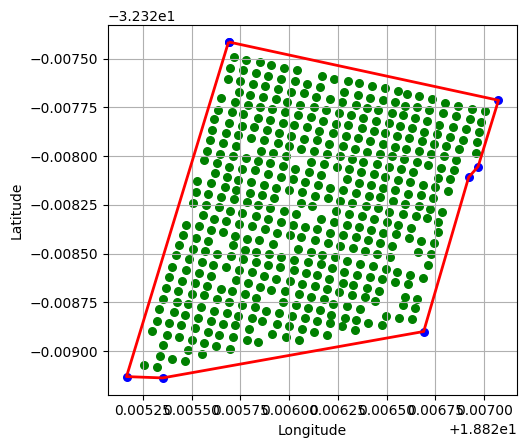

In [8]:
# Points for plotting corners
polygon_points = [Point(xy) for xy in zip(polygon_df['lng'], polygon_df['lat'])]
polygon_points_gdf = gpd.GeoDataFrame(polygon_df, geometry=polygon_points)

# Polygon shape from points
polygon_geometry = Polygon(polygon_points)
polygon_geometry_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon_geometry])

# Points for Trees
tree_points = [Point(xy) for xy in zip(trees_df['lng'], trees_df['lat'])]
tree_points_gdf = gpd.GeoDataFrame(trees_df, geometry=tree_points)

# Plot points
ax = polygon_points_gdf.plot(marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon on same axis as points
polygon_geometry_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label="Polygon Sides")
# Plot trees
tree_points_gdf.plot(ax=ax, marker='o', color='green', markersize=30, label="Trees")

# Bounding Box of polygon
poly_min_x, poly_min_y, poly_max_x, poly_max_y = polygon_geometry.bounds


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

plt.show()

### Step 3: Cluster Trees the Two Directions

In [9]:
x = np.array(trees_df['lng'])
y = np.array(trees_df['lat'])

# Find slopes of both directions
slopes = find_orchard_slopes(x,y)

dir_1_slope = slopes[0]
dir_2_slope = slopes[1]

# Clusters according to slope
# Get the y-intercept of a cluster for the current direction and the labels
dir_1_y_intercepts, dir_1_labels = cluster_trees_by_slope(x,y,slopes[0])
dir_2_y_intercepts, dir_2_labels = cluster_trees_by_slope(x,y,slopes[1])   

# Add the labels to the trees dataframe
trees_df["dir_1_labels"] = dir_1_labels
trees_df["dir_2_labels"] = dir_2_labels

# Print clustering results
print("Direction 1 slope: ", dir_1_slope)
print("Direction 2 slope: ", dir_2_slope)
print("Clusters for Direction 1: ", len(dir_1_y_intercepts))
print("Clusters for Direction 2: ", len(dir_2_y_intercepts))

c:\Users\benjr\Repos\Aerobotics_Technical_Assessment\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\benjr\Repos\Aerobotics_Technical_Assessment\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Direction 1 slope:  3.66120306825846
Direction 2 slope:  -0.23073766835165252
Clusters for Direction 1:  21
Clusters for Direction 2:  30


In [10]:
trees_df.head()

,id,lat,lng,ndre,ndvi,volume,area,row_index,tree_index,survey_id,dir_1_labels,dir_2_labels
0,54733434,-32.327964,18.826872,0.557,0.872,50.558,22.667,None,None,25319,0,26
1,54733276,-32.328189,18.826342,0.559,0.881,31.297,22.662,None,None,25319,8,8
2,54733233,-32.328320,18.825617,0.570,0.888,42.438,25.908,None,None,25319,13,25
3,54733009,-32.328759,18.826225,0.499,0.840,22.378,16.451,None,None,25319,17,13
5,54733279,-32.328016,18.826322,0.572,0.884,25.345,22.037,None,None,25319,4,19


#### Plot Direction Clusters

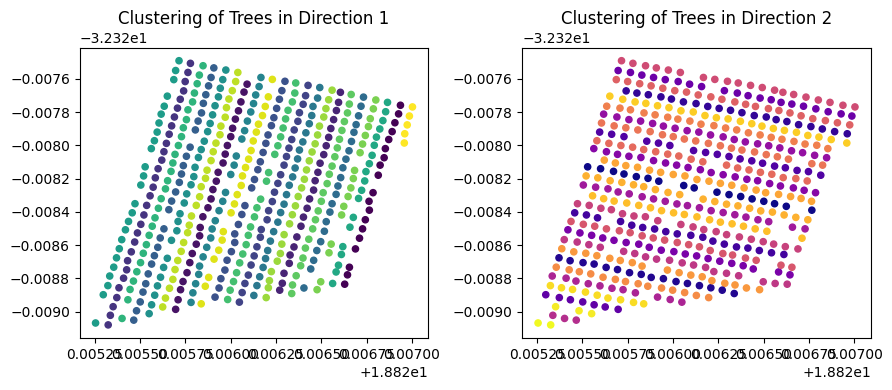

In [11]:
# Plot the clustering
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Dir 1 plot
scatter_1 = axes[0].scatter(x, y, c=dir_1_labels, cmap='viridis', s=20)
axes[0].set_title("Clustering of Trees in Direction 1")
# Dir 2 plot
scatter_2 = axes[1].scatter(x, y, c=dir_2_labels, cmap='plasma', s=20)
axes[1].set_title("Clustering of Trees in Direction 2")

plt.tight_layout()
plt.show()

### Step 4: Create LineString Grid, Find Outlier Distances, Map Tree Gaps to Grid

#### Geometry LineStrings in the current direction

In [12]:
# Geometry linestrings in the directions
dir_1_linestrings = linestrings_from_intercepts(dir_1_y_intercepts, dir_1_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)
dir_2_linestrings = linestrings_from_intercepts(dir_2_y_intercepts, dir_2_slope, poly_min_x, poly_max_x, poly_min_y, poly_max_y)


#### Calculte the distance between adjacent trees and find outliers

In [13]:

# Calculate the distances between adjacent trees in a clustered direction
dir_1_distances, dir_1_distances_dict = distance_between_adj_trees(trees_df, len(dir_1_y_intercepts), 'dir_1_labels')
dir_2_distances, dir_2_distances_dict = distance_between_adj_trees(trees_df, len(dir_2_y_intercepts), 'dir_2_labels')

# Get the outlier distances; tree_from and tree_to
dir_1_outliers = find_distance_outliers(dir_1_distances, dir_1_distances_dict)
dir_2_outliers = find_distance_outliers(dir_2_distances, dir_2_distances_dict)

print("Direction 1 Outliers: ")
print(dir_1_outliers)
print("Direction 2 Outliers: ")
print(dir_2_outliers)


Direction 1 Outliers: 
[(np.int32(0), np.int64(54733256), np.int64(54733173), 11.976906946811237), (np.int32(0), np.int64(54732970), np.int64(54733025), 12.648392454248075), (np.int32(5), np.int64(54733400), np.int64(54733208), 12.342439962708237), (np.int32(6), np.int64(54733214), np.int64(54733145), 13.05074911519492), (np.int32(7), np.int64(54733010), np.int64(54733003), 13.181500127024897), (np.int32(9), np.int64(54733296), np.int64(54733197), 12.303255481612064), (np.int32(10), np.int64(54732998), np.int64(54733152), 12.214261571164888), (np.int32(11), np.int64(54733442), np.int64(54733323), 12.56835820009797), (np.int32(11), np.int64(54733225), np.int64(54733433), 12.838523938845341), (np.int32(11), np.int64(54733414), np.int64(54733094), 19.293449453118047), (np.int32(12), np.int64(54733164), np.int64(54733160), 12.93128645678403), (np.int32(12), np.int64(54733415), np.int64(54732971), 13.513101716107448), (np.int32(13), np.int64(54733411), np.int64(54733076), 12.838519831753096

#### Map outliers to grid and find intersection points between them

In [14]:
dir_1_missing_points = find_intersects_between_trees(trees_df, dir_1_outliers, dir_1_linestrings, dir_2_linestrings)
dir_2_missing_points = find_intersects_between_trees(trees_df, dir_2_outliers, dir_2_linestrings, dir_1_linestrings)

print(dir_1_missing_points)
print(dir_2_missing_points)

[<POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.825 -32.328)>, <POINT (18.825 -32.329)>, <POINT (18.825 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.825 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>]
[<POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18

#### Remove any duplicate points

In [15]:
# Remove Duplicate Points
missing_points_combined =  list(set(dir_1_missing_points + dir_2_missing_points))
print(len(missing_points_combined))
print(missing_points_combined)

28
[<POINT (18.827 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.825 -32.329)>, <POINT (18.825 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.825 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.827 -32.328)>, <POINT (18.826 -32.329)>, <POINT (18.825 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.827 -32.328)>, <POINT (18.827 -32.329)>, <POINT (18.826 -32.329)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>, <POINT (18.826 -32.328)>]


#### Output Result

In [16]:
# Missing trees to dict output format
missing_trees = []
for point in missing_points_combined:
    missing_trees.append({"lat": point.y, "lng": point.x})

missing_trees

[{'lat': -32.328480817504875, 'lng': 18.826593800942387},
 {'lat': -32.328009146223145, 'lng': 18.826042812345104},
 {'lat': -32.32862476015992, 'lng': 18.82566989204446},
 {'lat': -32.3284446837792, 'lng': 18.825648530277967},
 {'lat': -32.32870628107072, 'lng': 18.826532219117603},
 {'lat': -32.328535779704204, 'lng': 18.826578788882607},
 {'lat': -32.328801537345385, 'lng': 18.826436031300016},
 {'lat': -32.32794938537412, 'lng': 18.82578381324257},
 {'lat': -32.327567325206864, 'lng': 18.826094263152985},
 {'lat': -32.32765389957317, 'lng': 18.82620846041011},
 {'lat': -32.32868196501634, 'lng': 18.826676889621424},
 {'lat': -32.32898678985186, 'lng': 18.825434785736242},
 {'lat': -32.329012241502724, 'lng': 18.825287030887722},
 {'lat': -32.328240598060184, 'lng': 18.826797442059494},
 {'lat': -32.32828364062529, 'lng': 18.825486036751055},
 {'lat': -32.32826844817025, 'lng': 18.826178669301687},
 {'lat': -32.32822358633059, 'lng': 18.825984241404498},
 {'lat': -32.328550570106735

#### Plot of missing trees

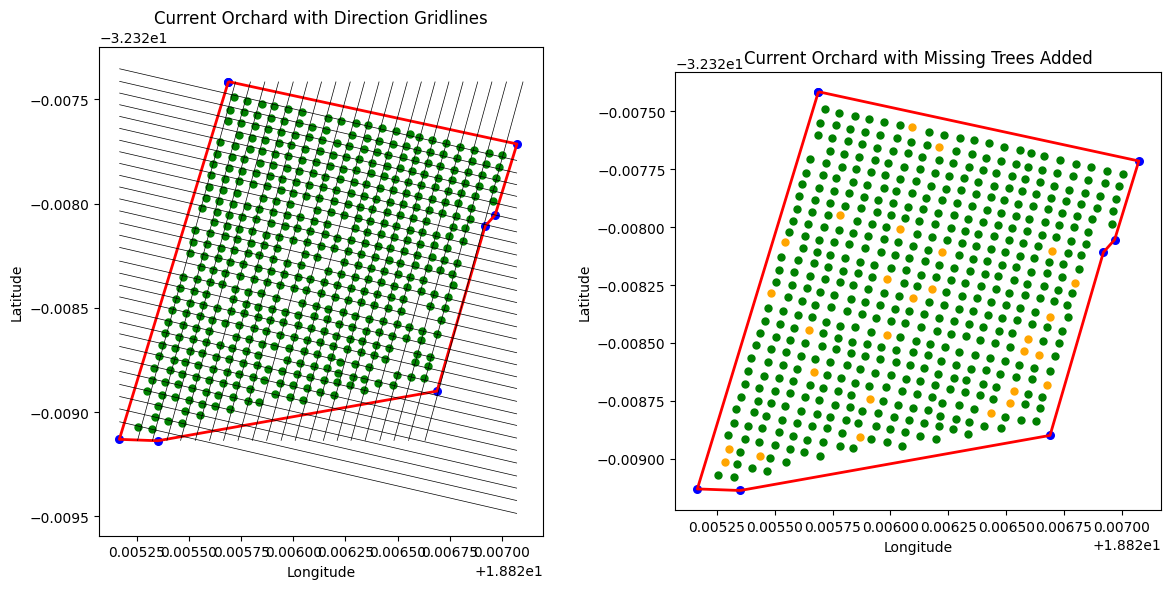

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot polygon corners
polygon_points_gdf.plot(ax=axes[0], marker='o', color='blue', markersize=30, label="Polygon Corners")
polygon_points_gdf.plot(ax=axes[1], marker='o', color='blue', markersize=30, label="Polygon Corners")
# Plot polygon sides
polygon_geometry_gdf.boundary.plot(ax=axes[0], color='red', linewidth=2, label="Polygon Sides")
polygon_geometry_gdf.boundary.plot(ax=axes[1], color='red', linewidth=2, label="Polygon Sides")


# Plot trees with gridlines on axes[0]
tree_points_gdf.plot(ax=axes[0], marker='o', color='green', markersize=25, label="Trees")
# Line Geometry for Grid
dir_1_geom_df = gpd.GeoDataFrame(geometry=dir_1_linestrings)
dir_1_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

dir_2_geom_df = gpd.GeoDataFrame(geometry=dir_2_linestrings)
dir_2_geom_df.plot(ax=axes[0], color='black', linewidth=0.5)

axes[0].set_title("Current Orchard with Direction Gridlines")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")


# Plot trees with missing trees on axes[1]
tree_points_gdf.plot(ax=axes[1], marker='o', color='green', markersize=25, label="Trees")
# Missing Trees
missing_points_combined_gdf = gpd.GeoDataFrame(geometry=missing_points_combined)
missing_points_combined_gdf.plot(ax=axes[1], marker='o', color='orange', markersize=25)

axes[1].set_title("Current Orchard with Missing Trees Added")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")


plt.tight_layout()
plt.show()